# Algorithmic Trading - Assignment 3

In [2]:
# load in appropriate packages
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
print('setup complete')

setup complete


In [3]:
class Assignment3():

    def __init__(self, train_data_file, test_data_file):

        self.train_data = pd.read_csv(train_data_file)
        self.test_data = pd.read_csv(test_data_file)

    @classmethod
    def evaluate(cls, model, test_features, test_labels):

            predictions = model.predict(test_features)

            absolute_errors = abs(predictions - test_labels)
            mae = np.mean(absolute_errors)
            print('Mean Absolute Error: {:0.4f}'.format(mae))

    def fill_na(self):

        self.train_data = self.train_data.ffill()
        self.train_data = self.train_data.bfill()
        self.test_data = self.test_data.ffill()

    def check_order(self, data):

        if not np.all(data.sort_values('epochhours').index == data.index):

            data = data.sort_values('epochhours')

    def calculate_mids(self):

        self.train_data['midDealerQuotes'] = (self.train_data['firm_executable_bid']
                                              + self.train_data['firm_executable_ask']) / 2

        self.train_data['midMarketEstimate'] = (self.train_data['market_estimate_bid']
                                              + self.train_data['market_estimate_ask']) / 2

        self.test_data['midDealerQuotes'] = (self.test_data['firm_executable_bid']
                                              + self.test_data['firm_executable_ask']) / 2

        self.test_data['midMarketEstimate'] = (self.test_data['market_estimate_bid']
                                              + self.test_data['market_estimate_ask']) / 2
    
    def calculate_returns(self, data):
        # LastPrice, midDealerQuotes, midMarketEstimate 
        data['LastPrice_rets'] = (data['last_price'] / data['last_price'].shift(1) -1) * 10000
        data['midDealerQuotes_rets'] = (data['midDealerQuotes'] / data['midDealerQuotes'].shift(1) -1) * 10000
        data['midMarketEstimate_rets'] = (data['midMarketEstimate'] / data['midMarketEstimate'].shift(1) -1) * 10000
    
    def make_matrices(self):
        self.Y = np.array(self.train_data['LastPrice_rets'][1:])
        self.X = np.ones((len(self.train_data)-1 , 3))
        self.X[:,1] = self.train_data['midDealerQuotes_rets'][1:]
        self.X[:,2] = self.train_data['midMarketEstimate_rets'][1:] 
        return
    
    def est_OLS(self):
        self.betas = np.linalg.inv(self.X.T @ self.X) @ self.X.T @ self.Y
        print('estimated betas are equal to')
        print(f'constant                              = {round(self.betas[0], 4)}')
        print(f'midDealerQuotes returns coefficient   = {round(self.betas[1], 4)}')
        print(f'midMarketEstimate returns coefficient = {round(self.betas[2], 4)}')
        
        return 
    
    def get_yhat(self):
        self.yhat = self.X @ self.betas
        return
    
    def get_r2(self):
        self.r2 = 1 - np.sum( (self.Y - self.yhat)**2) / np.sum( (self.Y - np.mean(self.Y))**2)
        print(f'R squared = {self.r2}')
        return 
    
    def get_MAE(self):
        self.MAE = np.mean(abs(self.Y - self.yhat))
        
        print(f'MAE       = {self.MAE}')
        return 
        
        
    def OLS_Q8(self):
        X = np.array(self.train_data[[
                'last_price'
            ]].iloc[:-1,:])
        
        Y = np.array(self.train_data['last_price'].iloc[1:])
        
        betas = np.linalg.inv(X.T @ X) @ X.T @ Y
        
        print(f'betas are {betas}')
        print()
        
        X_test = np.array(self.test_data[[
                'last_price'
            ]].iloc[0:-1, :])
        
        errors = self.test_data.iloc[1:, 1] - X_test @ betas
        print(errors)
        print()
        
        print(f'MAE of OLS question 8 = {np.mean(abs(errors))}')
        
    def flow_bid_and_ask(self):
        
        self.test_data.iloc[:, 7] = self.test_data.iloc[:, 6] * 1.001
        self.test_data.iloc[:, 8] = self.test_data.iloc[:, 6] * 0.999
        
        plt.plot(range(len(self.test_data.iloc[1:, 8])), self.test_data.iloc[1:,8])
        plt.plot(range(len(self.test_data.iloc[1:, 6])), self.test_data.iloc[1:,6])
        plt.plot(range(len(self.test_data.iloc[1:, 7])), self.test_data.iloc[1:,7])
        

    def generate_plots(self):

        # Create figure.
        fig, axs = plt.subplots(2, 2, sharex = True, sharey = True, figsize=(6,6))

        #fig.suptitle('Epoch Hours vs LastPrice, midDealerQuotes and midMarketEstimate')

        axs[0, 0].set_ylabel('Value')
        
        axs[0, 0].plot(
            self.train_data['epochhours'],
            self.train_data['last_price'],
            color = 'orange'
        )
        axs[0, 0].set_title("Last Price vs Epoch Hours")

        axs[0, 1].plot(
            self.train_data['epochhours'],
            self.train_data['midDealerQuotes'],
            color = 'green'
        )
        axs[0, 1].set_title("midDealerQuotes vs Epoch Hours")

        axs[1, 0].plot(
            self.train_data['epochhours'],
            self.train_data['midMarketEstimate'],
            color = 'blue'
        )

        axs[1, 0].set_title("midMarketEstimate vs Epoch Hours")

        axs[1, 0].set_xlabel('Epoch Hours')
        axs[1, 0].set_ylabel('Value')

        axs[1, 1].set_title("All vs Epoch Hours")

        axs[1, 1].set_xlabel('Epoch Hours')

        axs[1, 1].plot(
            self.train_data['epochhours'],
            self.train_data['last_price'],
            label = 'Last Price',
            color = 'orange',
            alpha = 0.5
        )

        axs[1, 1].plot(
            self.train_data['epochhours'],
            self.train_data['midDealerQuotes'],
            label = 'midDealerQuotes',
            color = 'green',
            alpha = 0.3
        )

        axs[1, 1].plot(
            self.train_data['epochhours'],
            self.train_data['midMarketEstimate'],
            label = 'midMarketEstimate',
            color = 'blue',
            alpha = 0.3
        )
        
        
        plt.tight_layout()
        plt.legend()
        plt.show()

    def random_forest(self):

        # Training features
        x_train = self.train_data[[
                'epochhours',
                'firm_executable_bid',
                'firm_executable_ask',
                'market_estimate_bid',
                'market_estimate_ask',
                'midDealerQuotes',
                'midMarketEstimate']].iloc[:-1,:]

        # Training target variable.
        y_train = self.train_data['last_price'].iloc[1:]

        # Testing features
        x_test = self.test_data[[
                'epochhours',
                'firm_executable_bid',
                'firm_executable_ask',
                'market_estimate_bid',
                'market_estimate_ask',
                'midDealerQuotes',
                'midMarketEstimate'
            ]].iloc[:-1,:]

        # Testing true y.
        y_test = self.test_data['last_price'].iloc[1:]

        # Number of trees.
        n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 1)]

        # Number of features at each split.
        max_features = ['auto', 'sqrt']

        # Maximum number of levels in tree.
        max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
        max_depth.append(None)

        # Minimum number of samples to split.
        min_samples_split = [2, 5, 10, 15]

        # Minimum number of samples required at each leaf.
        min_samples_leaf = [1, 2, 4, 6, 8]

        # Method of selecting samples for training each tree.
        bootstrap = [True, False]

        # Create the random grid
        random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
        }

        # Use the random grid to search for best hyperparameters
        # First create the base model to tune
        random_forest = RandomForestRegressor()

        # Random search of parameters, using 3 fold cross validation, 
        # search across 100 different combinations, and use all available cores
        random_forest_random_search = RandomizedSearchCV(
            estimator = random_forest,
            param_distributions = random_grid,
            n_iter = 100,
            cv = 3,
            verbose = 2,
            random_state = 42,
            n_jobs = -1
        )

        # Fit the random search model
        random_forest_random_search.fit(x_train, y_train)

        # Compare base model and optimised random forest.
        print('\nBase model:')
        base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
        base_model.fit(x_train, y_train)
        Assignment3.evaluate(base_model, x_test, y_test)

        print('\nBest Optimised model:')
        best_random = random_forest_random_search.best_estimator_
        Assignment3.evaluate(best_random, x_test, y_test)

        # Put predicted last price in test dataframe
        self.test_data.iloc[1:, 6] = best_random.predict(x_test)

In [4]:
# Setup filepaths.
# Get current working directory.
cwd = os.curdir

# Get data file paths.
train_data_file = os.path.join(cwd, 'Bond_MidModelTraining.csv')
test_data_file = os.path.join(cwd, 'Bond_QuoteLive.csv')

# Instantiate Assignment3
assignment = Assignment3(train_data_file, test_data_file)


In [5]:
# Fill nans.
assignment.fill_na()

# check if both sets are ordered properly by epochhours
assignment.check_order(assignment.train_data)
assignment.check_order(assignment.test_data)

# calculate mid prices
assignment.calculate_mids()

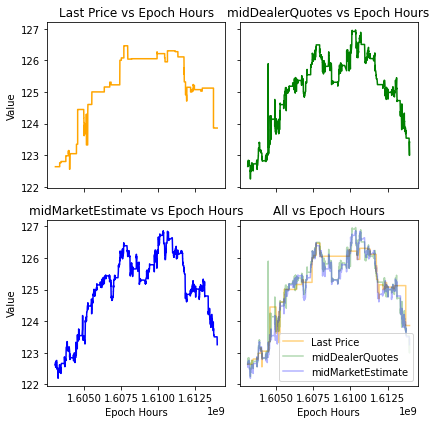

In [6]:
# fill in flow bid and ask
assignment.generate_plots()

In [7]:
# calculate returns
assignment.calculate_returns(assignment.train_data)

In [8]:
# OLS here
assignment.make_matrices()
assignment.est_OLS() # estimate OLS using analytical solution
assignment.get_yhat() # calculate the estimated Y
assignment.get_r2() # calculate r2
assignment.get_MAE() # calculate mean absolute error

estimated betas are equal to
constant                              = 0.0498
midDealerQuotes returns coefficient   = -0.0
midMarketEstimate returns coefficient = -0.0001
R squared = 4.479969395454475e-09
MAE       = 0.6517414190500567


In [9]:
# OLS Q8
assignment.OLS_Q8()

betas are [1.00000457]

1     -0.000572
2     -0.000572
3     -0.000572
4     -0.000572
5     -0.000572
         ...   
176   -0.000567
177   -0.000567
178   -0.000567
179   -0.000567
180   -0.000567
Name: last_price, Length: 180, dtype: float64

MAE of OLS question 8 = 0.00758085962394001


In [10]:
assignment.random_forest()

Fitting 3 folds for each of 100 candidates, totalling 300 fits

Base model:
Mean Absolute Error: 0.9848

Best Optimised model:
Mean Absolute Error: 0.1147


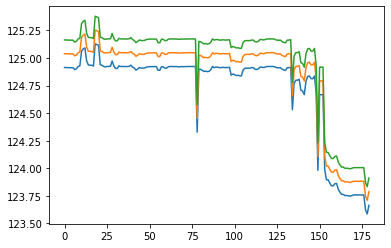

In [11]:
assignment.flow_bid_and_ask()

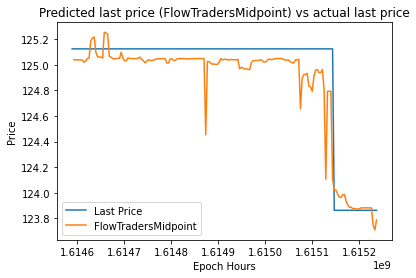

In [15]:
# Plot predicted last price and actual last price.

plt.plot(
    assignment.test_data['epochhours'],
    assignment.test_data['last_price'],
    label = 'Last Price'
)

plt.plot(
    assignment.test_data['epochhours'],
    assignment.test_data['FlowTradersMidpoint '],
    label = 'FlowTradersMidpoint'
)

plt.title('Predicted last price (FlowTradersMidpoint) vs actual last price')
plt.xlabel('Epoch Hours')
plt.ylabel('Price')
plt.legend()
plt.show()

###### Question 8c

###### Question 8d